# Data Extraction

In [49]:
# Normal imports
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#Specific imports
import rtree
import pygeos
import geopandas
from geopandas import GeoDataFrame
from shapely import wkt
from shapely.geometry import Point

#Internal imports
from src.data_extraction.data_extraction import extract_initial_data
from src.constants import (
    NEW_COLUMNS_NAMES,
    REMOVE_COLUMNS_BY_INPUT,
    NUM_VARIABLES_TO_SEE_DISTRIBUTION,
    BINARY_VARIABLES,
)
from src.preprocessing.preprocessing_utils import (
    generate_pandas_profiling_report,
    remove_duplicated_anuncios_id,
    find_single_value_columns,
    treatment_missing_values,
    visualize_distribution,
    visualize_binary_distribution,
    correlation_values,
    feature_engineering,
    get_location_name_w_gdf,
)

# Settings
warnings.filterwarnings("ignore")
%matplotlib inline


## Extract all dataset available, provided by idealista

In [3]:
df_assets, df_ine, df_osm, df_pois, df_polygons = extract_initial_data(
    root_dir="input_data"
)

## ASSETS - Basis

### General

In [4]:
# Change columns names to friendly ones
df_assets = df_assets.drop(columns=["ADTYPOLOGY", "ADOPERATION"])
df_assets.columns = NEW_COLUMNS_NAMES

In [5]:
# Generate pandas profiling
#FIXME: uncomment before commit
# generate_pandas_profiling_report(df=df_assets)

In [6]:
# See general statistics of df
description_df = df_assets.describe().transpose()
description_df

,count,mean,std,min,25%,50%,75%,max
fecha,94815.0,201808.613289,3.684625,201803.000000,201806.000000,201809.000000,201812.000000,2.018120e+05
precio,94815.0,396110.109160,417074.407623,21000.000000,160000.000000,262000.000000,467000.000000,8.133000e+06
precio_unitario_km2,94815.0,3661.051534,1700.499398,805.309735,2240.000000,3480.000000,4744.623034,9.997561e+03
area_construida,94815.0,101.397163,67.078259,21.000000,62.000000,83.000000,117.000000,9.850000e+02
n_habitaciones,94815.0,2.580900,1.244878,0.000000,2.000000,3.000000,3.000000,9.300000e+01
n_banos,94815.0,1.585456,0.843024,0.000000,1.000000,1.000000,2.000000,2.000000e+01
terraza,94815.0,0.355260,0.478595,0.000000,0.000000,0.000000,1.000000,1.000000e+00
ascensor,94815.0,0.695597,0.460157,0.000000,0.000000,1.000000,1.000000,1.000000e+00
aire_acondicionado,94815.0,0.448600,0.497354,0.000000,0.000000,0.000000,1.000000,1.000000e+00
amueblado,94815.0,2.922660,0.314865,1.000000,3.000000,3.000000,3.000000,3.000000e+00


In [7]:
# Remove duplicated anuncios_id
df_assets = remove_duplicated_anuncios_id(df_assets=df_assets, criteria="last")

All duplicated id_anuncio values are associated with the same fecha.


In [8]:
# Remove columns by input
df_assets = df_assets.drop(columns=REMOVE_COLUMNS_BY_INPUT)
print('Removed columns:', REMOVE_COLUMNS_BY_INPUT)

Removed columns: ['fecha', 'id_anuncio']


In [9]:
# Remove columns that only have one different value
remove_unique_value_columns = find_single_value_columns(df=df_assets)
df_assets = df_assets.drop(columns=remove_unique_value_columns)

Columns with only one distinct value: ['tipologia_imueble', 'operacion', 'ciudad']


### Missing Values

In [10]:
# Missing values
remove_columns_by_missing_values, df_assets = treatment_missing_values(df=df_assets)

Columns with missing values: Index(['ano_construccion', 'n_piso', 'exterior_interior', 'cat_calidad'], dtype='object')
ano_construccion: 59.95%
n_piso: 4.05%
exterior_interior: 6.79%
cat_calidad: 0.00%
Percentage of rows affected by dropping NaN values:", 0.09339876523666298


### Feature Engineering

In [11]:
# Feature Engineering: add new variables
(
    add_columns,
    remove_columns_by_creating_new_variables,
    df_assets,
) = feature_engineering(df=df_assets)

print("Columns added:", add_columns)
print('Columns removed by adding new:', remove_columns_by_creating_new_variables)

Columns added: ['interior', 'status_inmueble', 'antiguidade']
Columns removed by adding new: ['cat_ano_construccion', 'nueva_construccion', 'buen_estado', 'a_reformar', 'exterior_interior']


### Correlations

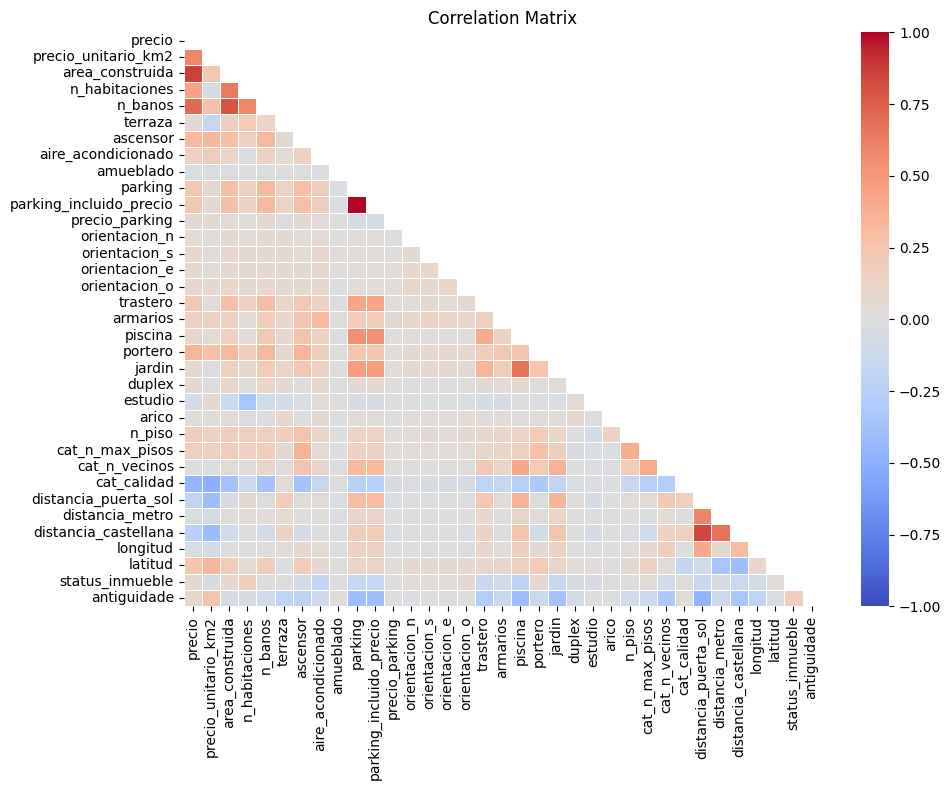

Correlated variables: precio, area_construida, Correlation: 0.8606170615020835
Correlated variables: parking, parking_incluido_precio, Correlation: 1.0
Correlated variables: distancia_puerta_sol, distancia_castellana, Correlation: 0.8363651289269339


In [12]:
# Correlation values
correlation_matrix, correlated_variables = correlation_values(df=df_assets, threshold=0.8)

### Visualizations

In [13]:
# visualize_distribution(
#     df=df_assets, numerical_columns=NUM_VARIABLES_TO_SEE_DISTRIBUTION
# )


#### Price Density (Precio del Vuelo)

<Axes: ylabel='Density'>

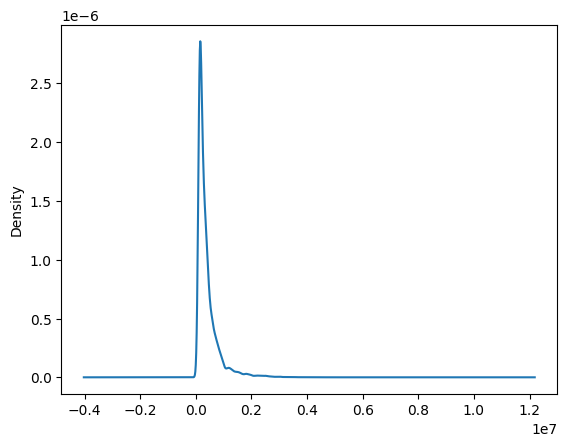

In [17]:
# Price density
df_assets.precio.plot.kde()

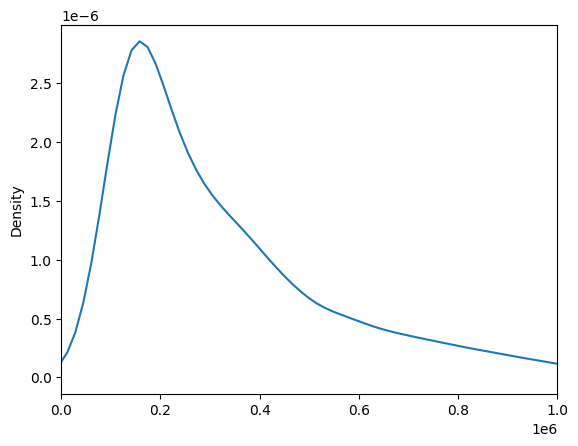

In [23]:
# Price density droping by 1M€
ax = df_assets.precio.plot.kde()
plt.xlim([0, 1000000])
plt.show()

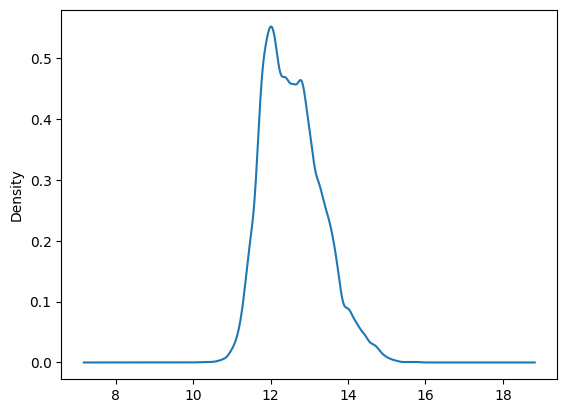

In [26]:
# Change scale of the price
df_assets['precio_logaritmico'] = np.log(df_assets['precio'])
ax = df_assets.precio_logaritmico.plot.kde()
plt.show()


Temas a tener en cuenta:

* La distribución de valores es multimodal
* La distribución de valores no es simétrica
* El rango de valores puede ser muy amplio

El precio depende de muchos factores, pero en la literatura existen dos grandes factores:

* Precio del suelo (el suelo donde está construido)
* Precio del vuelo (lo que está construido)

Para empezar, una forma de controlar el precio del suelo es incorporar información de la zona y una forma para controla el precio del suelo es normalizar por metros cuadrados (es nuestra variable __UNITPRICE__).

En la siguiente gráfica observamos el fenómeno de la multimodalidad, significa que podemos encontrarnos inmuebles con las mismas características constructivas con distintos precios €/m², ¿por qué?, principalmente por el otro factor: __el precio del suelo__.

#### Unit Price Density (Precio del suelo)

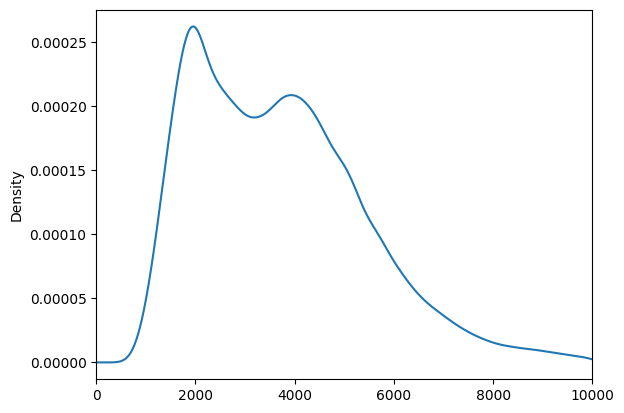

In [30]:
ax = df_assets.precio_unitario_m2.plot.kde()
plt.xlim([0, 10000])
plt.show()

#### Coordenadas

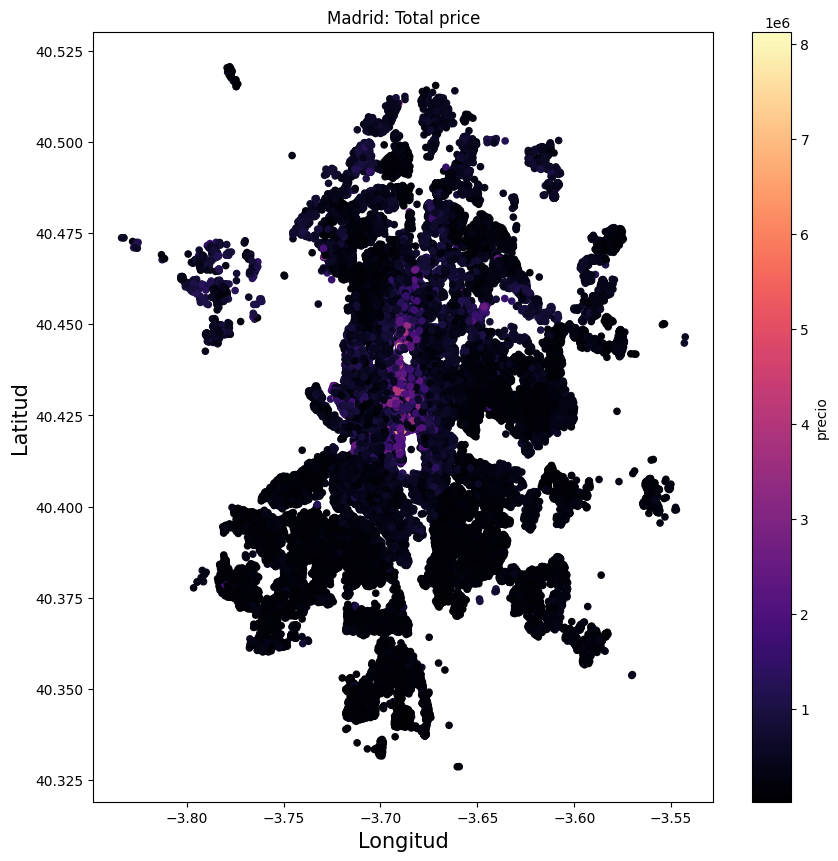

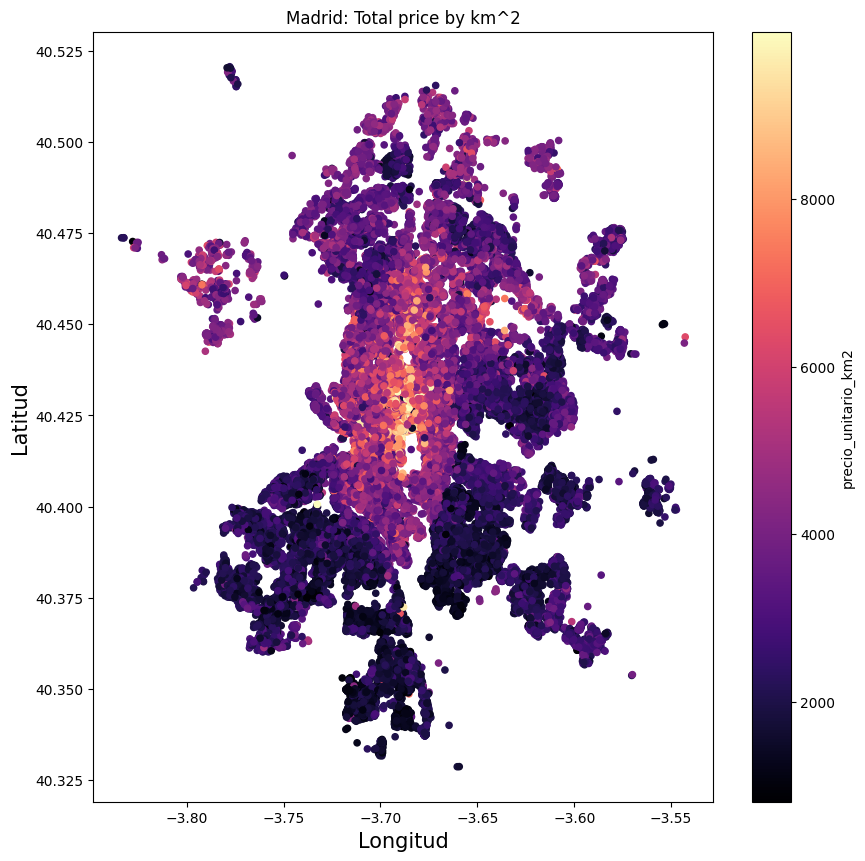

In [39]:
# Remove this observation because it is a clear outlier 
df_assets = df_assets[df_assets['latitud'] >= 37]

# Price Total €
cm = plt.cm.get_cmap('magma')  # or your colormap of choice
ax = df_assets.plot.scatter(x='longitud', y='latitud', c='precio',figsize=(10, 10), cmap=cm)
ax.set_xlabel('Longitud', fontsize=15)
ax.set_ylabel('Latitud', fontsize=15)
ax.set_title('Madrid: Total price')
ax.figure.show()

# Price Total by km^2 €
cm = plt.cm.get_cmap('magma')  # or your colormap of choice
ax = df_assets.plot.scatter(x='longitud', y='latitud', c='precio_unitario_m2',figsize=(10, 10), cmap=cm)
ax.set_xlabel('Longitud', fontsize=15)
ax.set_ylabel('Latitud', fontsize=15)
ax.set_title('Madrid: Total price by m^2')
ax.figure.show()

## Points of Interest - Open Street Map - Basis

In [41]:
df_osm

,ID,LAT,LNG,NOMBRE,CODE,SUBCODE
0,327897,40.397835,-3.723575,Tanatorio San Isidro,SHOP,DEPARTMENTSTORE
1,327920,40.454548,-3.703758,Parroquia San Francisco de Sales,POW,CHRISTIAN
2,328201,40.424741,-3.603675,Parroquia Nuestra Señora de Las Rosas,POW,CHRISTIAN
3,328303,40.484510,-3.704309,Parroquia Santa María de la Caridad,POW,CHRISTIAN
4,328304,40.485189,-3.705436,Colegio Público Lorenzo Luzuriaga,EDUCATION,SCHOOL
...,...,...,...,...,...,...
22071,327563,40.474151,-3.710319,I.E.S. Gregorio Marañón,EDUCATION,COLLEGE
22072,327564,40.477846,-3.701571,Centro de Salud Barrio del Pilar,HEALTH,HOSPITAL
22073,327565,40.477961,-3.700713,Colegio Público Camilo José Cela,EDUCATION,SCHOOL
22074,327566,40.465299,-3.711922,Escuela Infantil San José de Cluny,EDUCATION,NURSERY


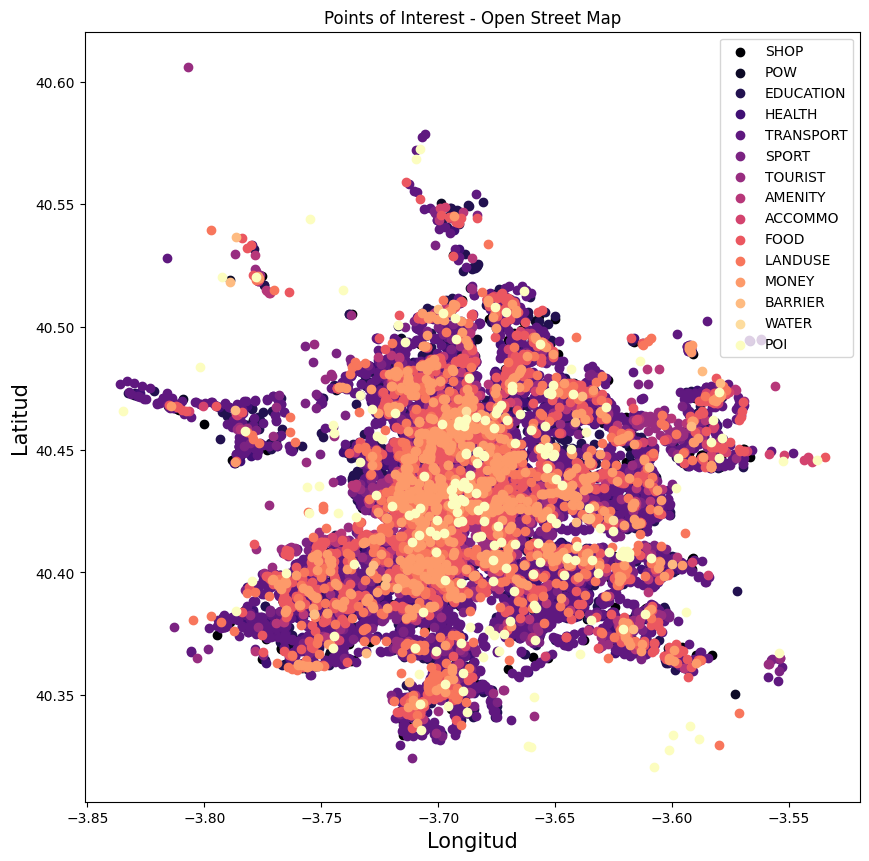

In [44]:
# Show points of interest
unique_codes = df_osm['CODE'].unique()
cmap = plt.cm.get_cmap('magma', len(unique_codes))

# Create scatter plot
fig, ax = plt.subplots(figsize=(10, 10))
for i, code in enumerate(unique_codes):
    subset = df_osm[df_osm['CODE'] == code]
    ax.scatter(subset['LNG'], subset['LAT'], c=cmap(i), label=code)

# Set labels and title
ax.set_xlabel('Longitud', fontsize=15)
ax.set_ylabel('Latitud', fontsize=15)
ax.set_title('Points of Interest - Open Street Map')

# Add legend
ax.legend()
plt.show()


## Polygons and INE censal polygons

In [45]:
df_ine

,WKT,CUSEC,MUNICIPIO,PROVINCIA
0,MULTIPOLYGON (((-3.711132737747107 40.42074740...,2807901001,Madrid,Madrid
1,MULTIPOLYGON (((-3.710154641722698 40.42294258...,2807901002,Madrid,Madrid
2,MULTIPOLYGON (((-3.707941047158223 40.42153271...,2807901003,Madrid,Madrid
3,MULTIPOLYGON (((-3.710253548084378 40.42078881...,2807901004,Madrid,Madrid
4,MULTIPOLYGON (((-3.708153461055955 40.41905842...,2807901006,Madrid,Madrid
...,...,...,...,...
2404,MULTIPOLYGON (((-3.581374133248912 40.46924639...,2807921026,Madrid,Madrid
2405,MULTIPOLYGON (((-3.590222178581825 40.46184580...,2807921027,Madrid,Madrid
2406,MULTIPOLYGON (((-3.598860010821234 40.50142314...,2807921028,Madrid,Madrid
2407,MULTIPOLYGON (((-3.598553418039264 40.46858234...,2807921029,Madrid,Madrid


In [46]:
df_polygons

,LOCATIONID,LOCATIONNAME,WKT,ZONELEVELID
0,0-EU-ES-28-07-001-079-16-002,Conde Orgaz-Piovera,"MULTIPOLYGON(((-3.63014 40.449394,-3.62633 40....",8
1,0-EU-ES-28-07-001-079-16-004,Pinar del Rey,"MULTIPOLYGON(((-3.655102 40.466807,-3.654251 4...",8
2,0-EU-ES-28-07-001-079-21-004,Timón,"MULTIPOLYGON(((-3.581744 40.479725,-3.60157 40...",8
3,0-EU-ES-28-07-001-079-01-001,Palacio,"MULTIPOLYGON(((-3.72044 40.42028,-3.72097 40.4...",8
4,0-EU-ES-28-07-001-079-01-003,Huertas-Cortes,"MULTIPOLYGON(((-3.696488 40.418813,-3.699685 4...",8
...,...,...,...,...
130,0-EU-ES-28-07-001-079-08-002,Fuentelarreina,"MULTIPOLYGON(((-3.733892 40.489401,-3.733132 4...",8
131,0-EU-ES-28-07-001-079-08-003,Peñagrande,"MULTIPOLYGON(((-3.726137 40.485498,-3.727173 4...",8
132,0-EU-ES-28-07-001-079-10-001,Los Cármenes,"MULTIPOLYGON(((-3.722623 40.404572,-3.722593 4...",8
133,0-EU-ES-28-07-001-079-09-001,Casa de Campo,"MULTIPOLYGON(((-3.770762 40.444122,-3.770713 4...",8


#### Polygons

In [75]:
# Convert WKT strings to Shapely geometries and create a GeoDataFrame
df_polygons['geometry'] = df_polygons['WKT'].apply(wkt.loads)
gdf_polygons = geopandas.GeoDataFrame(df_polygons['geometry'], crs='epsg:4326')

# Add additional columns to the GeoDataFrame
gdf_polygons['LOCATIONID'] = df_polygons['LOCATIONID']
gdf_polygons['LOCATIONNAME'] = df_polygons['LOCATIONNAME']

# Create Point geometries using longitude and latitude coordinates from df_assets
geometry = [Point(xy) for xy in zip(df_assets.longitud, df_assets.latitud)]

# Create a GeoDataFrame gdf_ads with df_prices data and geometry column
gdf_assets = GeoDataFrame(df_assets, crs="EPSG:4326", geometry=geometry)

# Apply a logarithmic scale transformation to the 'precio' column in gdf_ads
gdf_assets['precio_logaritmico'] = np.log(gdf_assets['precio'])


#### INE Censal Polygons

In [76]:
# Convert WKT strings to Shapely geometries and create a GeoDataFrame for census polygons
df_ine['geometry'] = df_ine['WKT'].apply(wkt.loads)
gdf_polygons_census = geopandas.GeoDataFrame(df_ine['geometry'], crs='epsg:4326')

# Add additional column 'CUSEC' to the GeoDataFrame representing census polygons
gdf_polygons_census['CUSEC'] = df_ine['CUSEC']

In [84]:
# Añadimos los codigos censales (CUSEC)
gdf_assets = geopandas.sjoin(gdf_assets, gdf_polygons_census, how="inner")
gdf_assets = gdf_assets.drop(columns=['index_right'])

# Ahora las zonas idealista (LOCATIONID, LOCATIONNAME)
gdf_assets = geopandas.sjoin(gdf_assets, gdf_polygons, how="inner")

In [85]:
gdf_assets

,precio,precio_unitario_km2,area_construida,n_habitaciones,n_banos,terraza,ascensor,aire_acondicionado,amueblado,parking,...,latitud,interior,status_inmueble,antiguidade,precio_logaritmico,geometry,CUSEC,index_right,LOCATIONID,LOCATIONNAME
0,126000,2680.851064,47,1,1,0,1,1,3,0,...,40.362485,1,3,13,11.744037,POINT (-3.76693 40.36248),2807911190,123,0-EU-ES-28-07-001-079-11-008,Pau de Carabanchel
1,235000,4351.851852,54,1,1,0,0,0,3,0,...,40.422430,0,2,118,12.367341,POINT (-3.71072 40.42243),2807901002,3,0-EU-ES-28-07-001-079-01-001,Palacio
2,373000,4973.333333,75,2,1,0,0,1,3,0,...,40.422190,1,2,103,12.829334,POINT (-3.71157 40.42219),2807901002,3,0-EU-ES-28-07-001-079-01-001,Palacio
4,228000,4560.000000,50,0,1,0,0,0,3,0,...,40.408741,1,2,88,12.337101,POINT (-3.71434 40.40874),2807901020,3,0-EU-ES-28-07-001-079-01-001,Palacio
5,498000,3921.259843,127,3,2,0,1,0,3,0,...,40.412639,1,3,118,13.118355,POINT (-3.70752 40.41264),2807901025,104,0-EU-ES-28-07-001-079-01-002,Lavapiés-Embajadores
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94810,347000,3017.391304,115,3,2,1,1,1,3,1,...,40.445810,1,2,9,12.757080,POINT (-3.59215 40.44581),2807920116,116,0-EU-ES-28-07-001-079-20-006,Rejas
94811,311000,3344.086022,93,2,2,0,1,1,3,1,...,40.445013,1,2,11,12.647548,POINT (-3.58938 40.44501),2807920121,116,0-EU-ES-28-07-001-079-20-006,Rejas
94812,342000,2826.446281,121,2,2,1,1,1,2,1,...,40.443196,1,2,9,12.742566,POINT (-3.57627 40.44320),2807920120,116,0-EU-ES-28-07-001-079-20-006,Rejas
94813,146000,2354.838710,62,3,1,0,0,0,2,0,...,40.447931,0,2,48,11.891362,POINT (-3.60869 40.44793),2807920091,78,0-EU-ES-28-07-001-079-20-007,Canillejas


### Visualizations

#### Polygons

<Axes: >

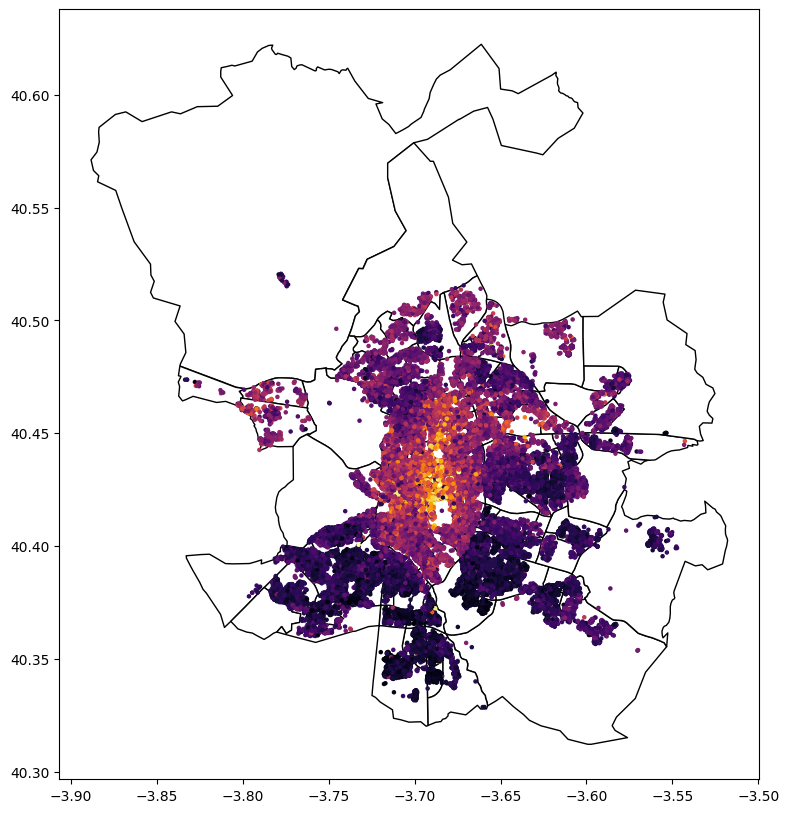

In [57]:
# Plot the GeoDataFrame gdf_polygons as white polygons with black edges on the base plot
base = gdf_polygons.plot(color='white', edgecolor='black', figsize=(10, 10))

# Overlay gdf_ads on the same plot, plotting points colored by 'precio_unitario_km2' column
gdf_assets.plot(ax=base, marker='o', column='precio_unitario_km2', markersize=5, cmap='inferno')

<Axes: >

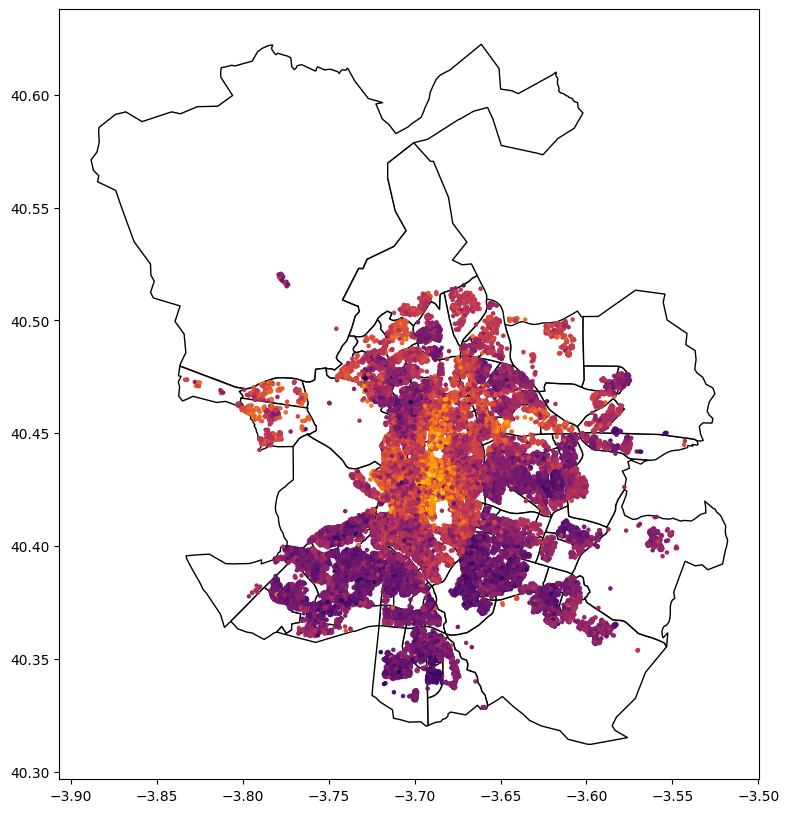

In [59]:
# Use logaritmic price
# Plot the GeoDataFrame gdf_polygons as white polygons with black edges on the base plot
base = gdf_polygons.plot(color='white', edgecolor='black', figsize=(10, 10))

# Overlay gdf_ads on the same plot, plotting points colored by 'precio_logaritmico' column
gdf_assets.plot(ax=base, marker='o', column='precio_logaritmico', markersize=5, cmap='inferno')


#### INE Censal Polygons

<Axes: >

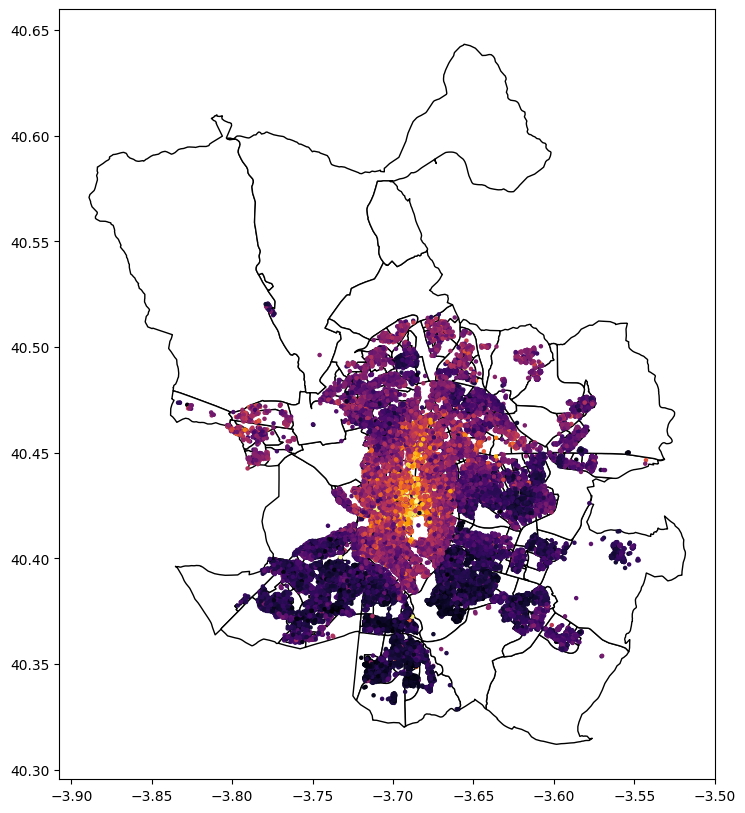

In [62]:
# Plot the census polygons as white polygons with black edges on the base plot
base = gdf_polygons_census.plot(color='white', edgecolor='black', figsize=(10, 10))

# Overlay gdf_ads on the same plot, plotting points colored by 'precio_unitario_km2' column
gdf_assets.plot(ax=base, marker='o', column='precio_unitario_km2', markersize=5, cmap='inferno')
